In [143]:
#profitableHospital-project

In [144]:
#dependencies
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import tensorflow
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [145]:
# ... File Imports

In [146]:
#2017 Hospital Data from Centers for Medicare Services
df = pd.read_csv("Medicare_Hospital_Cost_Report_PUF_2017.csv")
df.head(2)

C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (105) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Total Other Income,Total Income,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,4492364.0,2638799.0,NaN,2638799.0,0.453498,1237912.0,4026663.0,NaN,NaN,599181
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,31174.0,-1114660.0,NaN,-1114660.0,0.173114,391215.0,4981119.0,NaN,NaN,601095


In [147]:
#Quick Check
df['Provider CCN'].count()

6171

In [148]:
#Certificate of Need Status by State File
conTable = pd.read_csv("certificateofneedstatesTable.csv")
conTable.head(2)

,State Code,CON
0,AK,1
1,AL,1


In [149]:
#String to Numeric Conversion Table for Urban v. Rural designation
urbanTable = pd.read_csv("ruralversusurbanTable.csv")
urbanTable.head()

,Rural Versus Urban,Urban
0,U,1
1,R,0


In [150]:
#Lattitude & Longitude for the 2017 hospital listing
#geoTable = pd.read_csv("geocoded2017.csv")
#geoTable.head(2)

In [151]:
# ... Appending of source files into one main working file

In [152]:
mainFile1 = df

In [153]:
#Append a lattitude & longitude
#mainFile1 = pd.merge(mainFile1, geoTable, how= "left", on=['Provider CCN'])
#mainFile1.head(2)

In [154]:
#Quick Check
mainFile1['Provider CCN'].count()

6171

In [155]:
#Append certificate of need indicator
mainFile1 = pd.merge(mainFile1, conTable, how= "left", on=['State Code'])
#mainFile1.head()

In [156]:
#Quick Check
mainFile1['Provider CCN'].count()

6171

In [157]:
#Append a numeric representation of rural v. urban
mainFile1 = pd.merge(mainFile1, urbanTable, how= "left", on=['Rural Versus Urban'])

In [158]:
#Quick Check
mainFile1['Provider CCN'].count()

6171

In [159]:
mainFile1.head(2)

,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num,CON,Urban
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,NaN,2638799.0,0.453498,1237912.0,4026663.0,NaN,NaN,599181,1.0,1.0
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,NaN,-1114660.0,0.173114,391215.0,4981119.0,NaN,NaN,601095,1.0,0.0


In [160]:
mainFile1.to_csv("mainFile1.csv", index=False, header=True)

In [161]:
# ... Add calculated fields

In [162]:
mainFile2 = mainFile1

In [163]:
#Append calculated field inpatient percent
inpatient = mainFile2["Inpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Inpatient %"] = inpatient
#mainFile2.head()

In [164]:
#Append calculated field outpatient percent
outpatient = mainFile2["Outpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Outpatient %"] = outpatient
#mainFile2.head()

In [165]:
#Append calculated field charity percent
charity = mainFile2["Cost of Charity Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Charity %"] = charity
#mainFile2.head()

In [166]:
#Append calculated field uncompensated percent
uncompensated = mainFile2["Cost of Uncompensated Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Uncompensated %"] = charity
#mainFile2.head()

In [167]:
#Append calculated field revenue per discharge
revdischarge = mainFile2["Net Patient Revenue"]/mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]
mainFile2["Rev Per Discharge"] = revdischarge
#mainFile2.head()

In [168]:
#Append calculated field revenue per bed
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Number of Beds"]
mainFile2["Rev Per Bed"] = revbed
#mainFile2.head()

In [169]:
#Append calculated field revenue per bed day
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Total Bed Days Available"]
mainFile2["Rev Per Bed Days"] = revbed
#mainFile2.head()

In [170]:
#Append calculated field revs per fte
revfte = mainFile2["Net Patient Revenue"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Rev Per FTE"] = revfte
#mainFile2.head()

In [171]:
#Append calculated field discharges per bed
volbed = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Number of Beds"]
mainFile2["Discharges Per Bed"] = volbed
#mainFile2.head()

In [172]:
#Append calculated field discharges per bed day
voldays = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Total Bed Days Available"]
mainFile2["Discharges Per Bed Days"] = voldays
#mainFile2.head()

In [173]:
#Append calculated field discharges per bed
volfte = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Discharges Per FTE"] = volbed
#mainFile2.head()

In [174]:
#labor percent
wagepercent = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
wagepercent = wagepercent / mainFile2["Net Patient Revenue"]
mainFile2["Labor %"] = wagepercent
#wagepercent.head()

In [175]:
#Overhead percent
overheadpercent = mainFile2["Overhead Non-Salary Costs"] / mainFile2["Net Patient Revenue"]
mainFile2["Overhead %"] = overheadpercent
#overheadpercent.head()

In [176]:
#Depreciation percent
deprpercent = mainFile2["Depreciation Cost"] / mainFile2["Net Patient Revenue"]
mainFile2["Depreciation %"] = deprpercent
#overheadpercent.head()

In [177]:
#labor Per FTE
wagefte = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
wagefte = wagefte / mainFile2["FTE - Employees on Payroll"]
mainFile2["Labor Exp Per FTE"] = wagefte
#wagepercent.head()

In [178]:
#Overhead Expense Per Bed
overbed = mainFile2["Overhead Non-Salary Costs"] / mainFile2["Number of Beds"]
mainFile2["Overhead Exp Per Bed"] = overbed
#wagepercent.head()

In [179]:
#Append calculated field net income percent to file
profit = mainFile2["Net Income"]/mainFile2["Net Patient Revenue"]
mainFile2["Net Income %"] = profit
#mainFile2.head()

In [180]:
# Review net income percent for outlier reduction approach
netinc = mainFile2["Net Income %"]
#netinc.head()

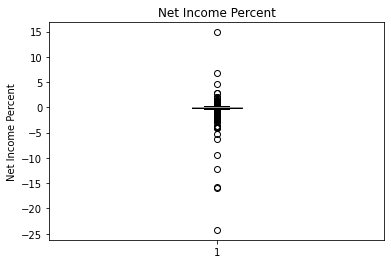

In [181]:
# Box plot and outlier calculations for outlier approach
netinc2 = netinc.dropna(how='any')
chartdata = netinc2
fig1, ax1 = plt.subplots()
ax1.set_title('Net Income Percent')
ax1.set_ylabel('Net Income Percent')
ax1.boxplot(chartdata)
plt.show()

In [182]:
#Quartile calculations
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of profit percent is: {lowerq}")
print(f"The upper quartile of profit percent is: {upperq}")
print(f"The interquartile range of profit percent is: {iqr}")
print(f"The the median of profit percent is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of profit percent is: -0.030653238847723918
The upper quartile of profit percent is: 0.11379730445563284
The interquartile range of profit percent is: 0.14445054330335677
The the median of profit percent is: 0.0380451602645128 
Values below -0.24732905380275907 could be outliers.
Values above 0.330473119410668 could be outliers.


In [183]:
#Create a bronze, silver, gold score for clasifying net income performance
bins = [-100, -0.030605, 0.113797, 100]
group_names = ["3", "2", "1"]

In [184]:
#Add a bronze, silver, gold scoring system to the dataset
mainFile2["Net Income Score"] = pd.cut(mainFile2["Net Income %"], bins, labels=group_names, include_lowest=True)
#mainFile2.head()

In [185]:
#Quick check on distribution of bronze, silver and gold
mainFile2['Net Income Score'].value_counts()

2    2945
1    1473
3    1473
Name: Net Income Score, dtype: int64

In [186]:
#Quick Check
mainFile2['Provider CCN'].count()

6171

In [187]:
mainFile2.to_csv("mainFile2.csv", index=False, header=True)

In [188]:
# ..... File targeting

In [189]:
mainFile3 = mainFile2
mainFile3['Provider CCN'].count()

6171

In [190]:
#Targets dataset on Colorad0
#mainFile3 = mainFile3.loc[df['State Code'] == 'CO']

In [191]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'PR']

In [192]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'GU']

In [193]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'VI']

In [194]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'MP']

In [195]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'HI']

In [196]:
#Removes state
mainFile3 = mainFile3.loc[df['State Code'] != 'AK']

In [197]:
#Quick Check ... Lose 117 to state code reduction
mainFile3['Provider CCN'].count()

6054

In [198]:
#Remove hospitals that did not report revenue (Lose 273 to missing or unreported revenue events)
mainFile3 = mainFile3.loc[mainFile2['Net Patient Revenue'] >= 0.1]

In [199]:
#Quick Check
mainFile3['Provider CCN'].count()

5781

In [200]:
#Remove hospitals that discharged less than 15 patients (Lose 49 by placing a 15 patient minimum for study eligibility)
mainFile3 = mainFile3.loc[mainFile2['Total Discharges (V + XVIII + XIX + Unknown)'] >= 15]

In [201]:
#Quick Check
mainFile3['Provider CCN'].count()

5732

In [202]:
#Remove hospitals with less than 10 employees on payroll (Lose 23 by placing a 10 employee minimum for study eligibility)
mainFile3 = mainFile3.loc[mainFile2['FTE - Employees on Payroll'] >= 10]

In [203]:
#Quick Check
mainFile3['Provider CCN'].count()

5709

In [204]:
#Targets dataset on certificate of need states
#mainFile3 = mainFile3.loc[mainFile2['CON'] == 1]

In [205]:
#Remove net income outliers
#mainFile3 = mainFile3.loc[mainFile2['Net Income %'] <= .3304]

In [206]:
#Remove net income outliers
#mainFile3 = mainFile3.loc[mainFile2['Net Income %'] >= -.2473]

In [207]:
#Remove Discharges Per Bed outliers
#mainFile3 = mainFile3.loc[mainFile2['Rev Per Discharge'] <= 90000]

In [208]:
#Remove Rev Per Bed outliers
#mainFile3 = mainFile3.loc[mainFile2['Rev Per Bed'] <= 2000000]

In [209]:
#Remove Rev Per FTE outliers
#mainFile3 = mainFile3.loc[mainFile2['Rev Per FTE'] <= 500000]

In [210]:
#Remove Rev Per Discharge outliers
#mainFile3 = mainFile3.loc[mainFile2['Rev Per Discharge'] <= 175000]

In [211]:
#Targets dataset on STH locations (~56% of eligible continental US locations are STH providers)
mainFile3 = mainFile3.loc[mainFile2['CCN Facility Type'] == 'STH']

In [212]:
#Quick Check
mainFile3['Provider CCN'].count()

3194

In [213]:
#Quick check on distribution of bronze, silver and gold
#mainFile3['Net Income Score'].value_counts()

In [214]:
#Quick Check
mainFile3['Provider CCN'].count()

3194

In [215]:
mainFile3.to_csv("mainFile3.csv", index=False, header=True)

In [216]:
# ... Target file based on relevant columns

In [217]:
mainFile4 = mainFile3

In [218]:
#Targeting the dataset on metrics important to Kent
mainFile4 = mainFile4[['Provider CCN','Hospital Name','Street Address','City','State Code','Zip Code','CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev Per Discharge','Rev Per Bed','Rev Per Bed Days','Rev Per FTE','Discharges Per Bed','Discharges Per Bed Days','Discharges Per FTE','Net Income %', 'Net Income Score', 'Labor %', 'Overhead %', 'Depreciation %', 'Labor Exp Per FTE', 'Overhead Exp Per Bed']]
mainFile4.head()


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,CON,Urban,Inpatient %,Outpatient %,...,Discharges Per Bed,Discharges Per Bed Days,Discharges Per FTE,Net Income %,Net Income Score,Labor %,Overhead %,Depreciation %,Labor Exp Per FTE,Overhead Exp Per Bed
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,1.0,1.0,0.311881,0.688119,...,6.214286,0.067547,6.214286,0.308395,1,0.715116,0.627406,0.031451,18996.972990,76691.942857
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,1.0,0.0,0.325730,0.674270,...,3.062500,0.050205,3.062500,-0.337043,3,0.509928,0.924882,0.073496,61909.838473,47792.984375
2,450178,PECOS COUNTY MEMORIAL HOSPITAL,386 W IH-10,FORT STOCKTON,TX,79735,0.0,0.0,0.240965,0.759035,...,4.160000,0.077037,4.160000,0.232354,1,0.967445,0.813624,0.104039,16085.224911,80717.240000
4,110003,MAYO CLINIC HEALTH SYSTEM WAYCROSS,1900 TEBEAU STREET,WAYCROSS,GA,31501,1.0,0.0,0.391293,0.608707,...,13.612903,0.113441,13.612903,-0.132444,3,0.501340,0.734530,NaN,25293.787024,220772.367742
5,250025,GILMORE MEMORIAL REGIONAL MEDICAL CE,1105 EARL FRYE BLVD,AMORY,MS,38821,1.0,0.0,0.364763,0.635237,...,8.589474,0.071579,8.589474,-0.132426,3,0.414191,0.826683,0.119266,21706.316534,109668.063158


In [219]:
# Identify incomplete rows
mainFile4.count()

Provider CCN               3194
Hospital Name              3194
Street Address             3193
City                       3194
State Code                 3194
Zip Code                   3194
CON                        3194
Urban                      3194
Inpatient %                3193
Outpatient %               3182
Charity %                  3016
Uncompensated %            3016
Rev Per Discharge          3194
Rev Per Bed                3194
Rev Per Bed Days           3194
Rev Per FTE                3194
Discharges Per Bed         3194
Discharges Per Bed Days    3194
Discharges Per FTE         3194
Net Income %               3193
Net Income Score           3193
Labor %                    3183
Overhead %                 3194
Depreciation %             3169
Labor Exp Per FTE          3183
Overhead Exp Per Bed       3194
dtype: int64

In [220]:
mainFile4 = mainFile4.dropna(how='any')

In [221]:
# Identify incomplete rows
mainFile4.count()

Provider CCN               2982
Hospital Name              2982
Street Address             2982
City                       2982
State Code                 2982
Zip Code                   2982
CON                        2982
Urban                      2982
Inpatient %                2982
Outpatient %               2982
Charity %                  2982
Uncompensated %            2982
Rev Per Discharge          2982
Rev Per Bed                2982
Rev Per Bed Days           2982
Rev Per FTE                2982
Discharges Per Bed         2982
Discharges Per Bed Days    2982
Discharges Per FTE         2982
Net Income %               2982
Net Income Score           2982
Labor %                    2982
Overhead %                 2982
Depreciation %             2982
Labor Exp Per FTE          2982
Overhead Exp Per Bed       2982
dtype: int64

In [222]:
#Output targeted file
mainFile4.to_csv("mainFile4.csv", index=False, header=True)

In [223]:
# ... Net Income to feature review

In [224]:
targetFile5 = mainFile4

In [225]:
#Outlier Review
chartdata = targetFile5["Discharges Per Bed"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of profit percent is: {lowerq}")
print(f"The upper quartile of profit percent is: {upperq}")
print(f"The interquartile range of profit percent is: {iqr}")
print(f"The the median of profit percent is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of profit percent is: 32.78753791708797
The upper quartile of profit percent is: 55.0977833485895
The interquartile range of profit percent is: 22.310245431501535
The the median of profit percent is: 46.09932011795544 
Values below -0.6778302301643393 could be outliers.
Values above 88.56315149584181 could be outliers.


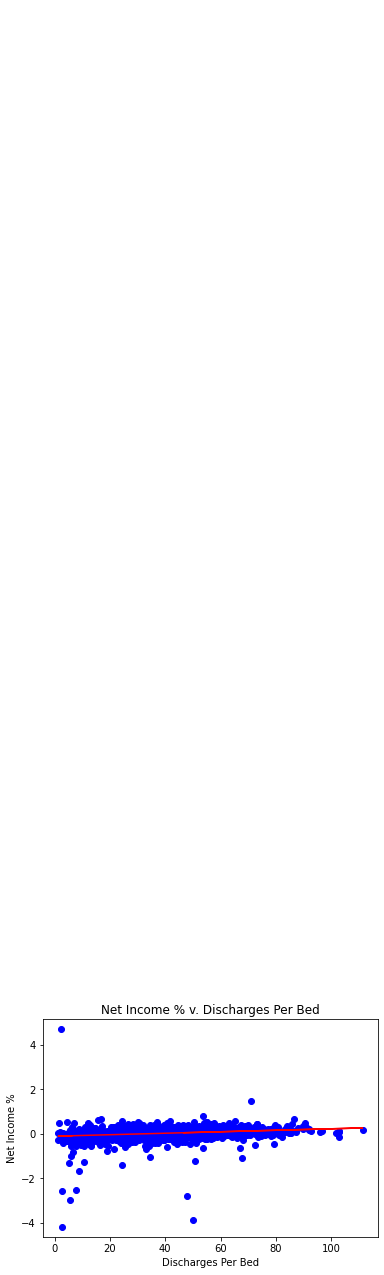

The correlation coefficient is 0.24
The line equation is as follows:  y = 0.0x + -0.11


In [226]:
#NI v. discharges per bed
x_axis = targetFile5["Discharges Per Bed"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Discharges Per Bed")
plt.xlabel("Discharges Per Bed")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

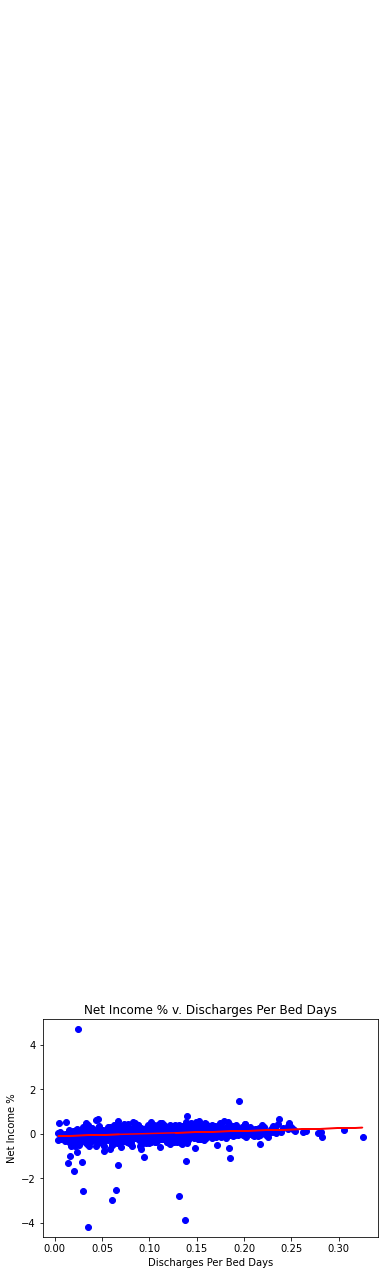

The correlation coefficient is 0.23
The line equation is as follows:  y = 1.19x + -0.11


In [227]:
#NI v. discharges per bed days
x_axis = targetFile5["Discharges Per Bed Days"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Discharges Per Bed Days")
plt.xlabel("Discharges Per Bed Days")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [228]:
#Outlier Review
chartdata = targetFile5["Rev Per Bed"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of profit percent is: {lowerq}")
print(f"The upper quartile of profit percent is: {upperq}")
print(f"The interquartile range of profit percent is: {iqr}")
print(f"The the median of profit percent is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of profit percent is: 804362.7826709477
The upper quartile of profit percent is: 1590219.5808389264
The interquartile range of profit percent is: 785856.7981679786
The the median of profit percent is: 1154970.1033051123 
Values below -374422.41458102036 could be outliers.
Values above 2769004.778090894 could be outliers.


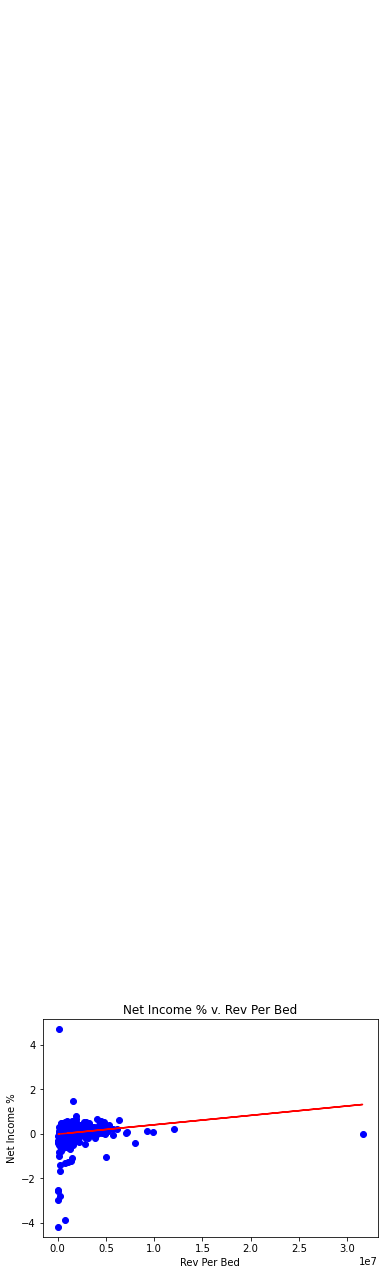

The correlation coefficient is 0.18
The line equation is as follows:  y = 0.0x + -0.02


In [229]:
#NI v. Revenue Per Bed
x_axis = targetFile5["Rev Per Bed"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Rev Per Bed")
plt.xlabel("Rev Per Bed")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [234]:
#Outlier Review
chartdata = targetFile5["Rev Per FTE"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range is: {iqr}")
print(f"The the median is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 158625.1909001212
The upper quartile is: 238479.63003260596
The interquartile range is: 79854.43913248475
The the median is: 195253.8165384751 
Values below 38843.532201394075 could be outliers.
Values above 358261.2887313331 could be outliers.


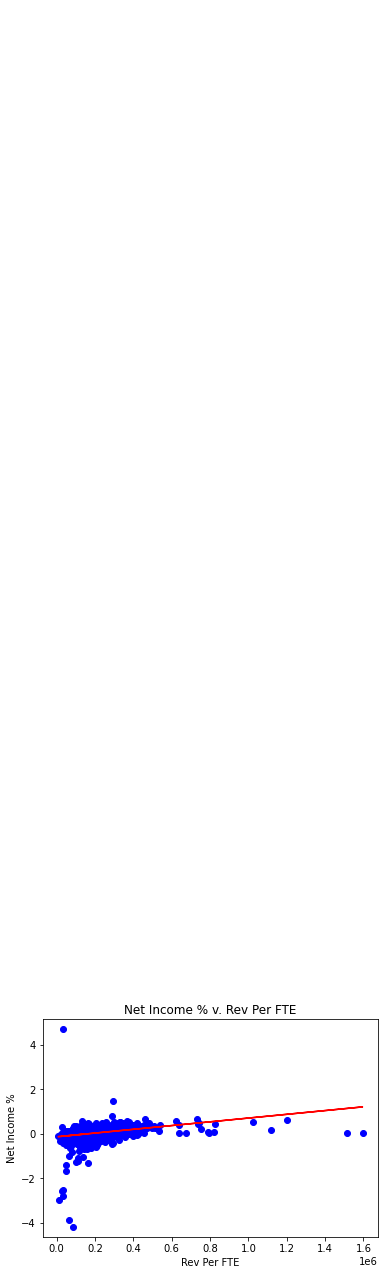

The correlation coefficient is 0.32
The line equation is as follows:  y = 0.0x + -0.14


In [239]:
#NI v. Rev Per FTE
targetFile6 = targetFile5
# targetFile6 = targetFile5.loc[targetFile5['Rev Per FTE'] <= 1000000]
# targetFile6 = targetFile6.loc[targetFile5['Net Income %'] <= .35]
# targetFile6 = targetFile6.loc[targetFile5['Net Income %'] >= -.25]
x_axis = targetFile6["Rev Per FTE"]
y_axis = targetFile6["Net Income %"]
plt.title("Net Income % v. Rev Per FTE")
plt.xlabel("Rev Per FTE")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [90]:
#Outlier Review
chartdata = targetFile5["Rev Per Discharge"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of profit percent is: {lowerq}")
print(f"The upper quartile of profit percent is: {upperq}")
print(f"The interquartile range of profit percent is: {iqr}")
print(f"The the median of profit percent is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of profit percent is: 20249.235054374352
The upper quartile of profit percent is: 34700.51973767634
The interquartile range of profit percent is: 14451.284683301987
The the median of profit percent is: 25606.19220656314 
Values below -1427.6919705786277 could be outliers.
Values above 56377.44676262932 could be outliers.


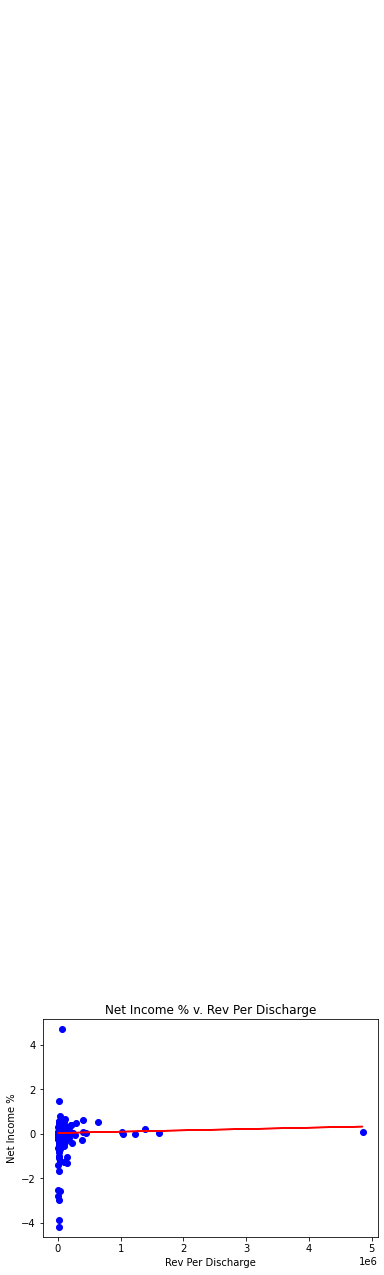

The correlation coefficient is 0.03
The line equation is as follows:  y = 0.0x + 0.04


In [91]:
#NI v. Rev Per Discharge
x_axis = targetFile5["Rev Per Discharge"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Rev Per Discharge")
plt.xlabel("Rev Per Discharge")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [131]:
#Outlier Review
chartdata = targetFile5["Labor Exp Per FTE"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range is: {iqr}")
print(f"The the median of is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 75888.99972993067
The upper quartile is: 96877.119655674
The interquartile range is: 20988.119925743333
The the median of is: 85290.95879189257 
Values below 44406.81984131567 could be outliers.
Values above 128359.29954428901 could be outliers.


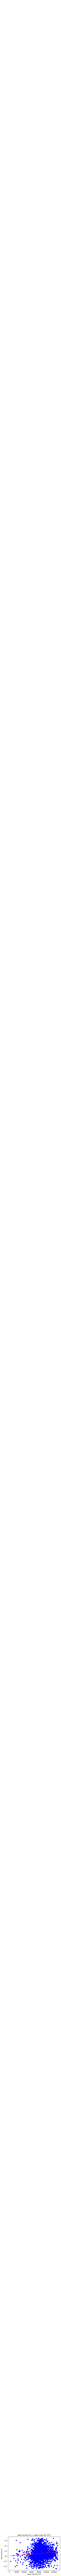

The correlation coefficient is 0.09
The line equation is as follows:  y = 0.0x + 0.0


In [137]:
#NI v. Labor Expense Per FTE
targetFile6 = targetFile5.loc[targetFile5['Labor Exp Per FTE'] <= 130000]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] <= .35]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] >= -.25]
x_axis = targetFile6["Labor Exp Per FTE"]
y_axis = targetFile6["Net Income %"]
plt.title("Net Income % v. Labor Exp Per FTE")
plt.xlabel("Labor Exp Per FTE")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [139]:
#Outlier Review
chartdata = targetFile5["Overhead %"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range is: {iqr}")
print(f"The the median of is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 0.5621077646917462
The upper quartile is: 0.6926348487601393
The interquartile range is: 0.13052708406839308
The the median of is: 0.6208035039207582 
Values below 0.36631713858915654 could be outliers.
Values above 0.8884254748627289 could be outliers.


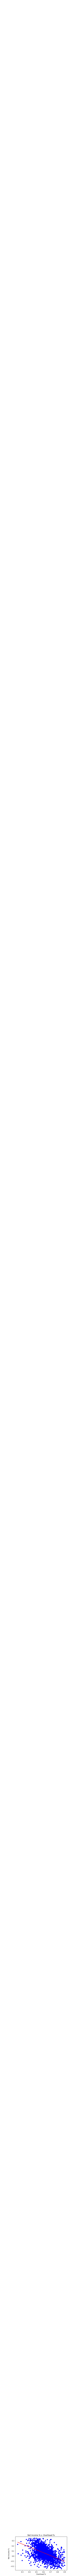

The correlation coefficient is -0.5
The line equation is as follows:  y = -0.56x + 0.4


In [140]:
#NI v. Overhead Percent
targetFile6 = targetFile5.loc[targetFile5['Overhead %'] <= .90]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] <= .35]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] >= -.25]
x_axis = targetFile6["Overhead %"]
y_axis = targetFile6["Net Income %"]
plt.title("Net Income % v. Overhead %")
plt.xlabel("Overhead %")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [243]:
#Outlier Review
chartdata = targetFile5["Labor %"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range is: {iqr}")
print(f"The the median of is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 0.3751075906483552
The upper quartile is: 0.5373285012672162
The interquartile range is: 0.16222091061886101
The the median of is: 0.45013593995322915 
Values below 0.13177622472006367 could be outliers.
Values above 0.7806598671955077 could be outliers.


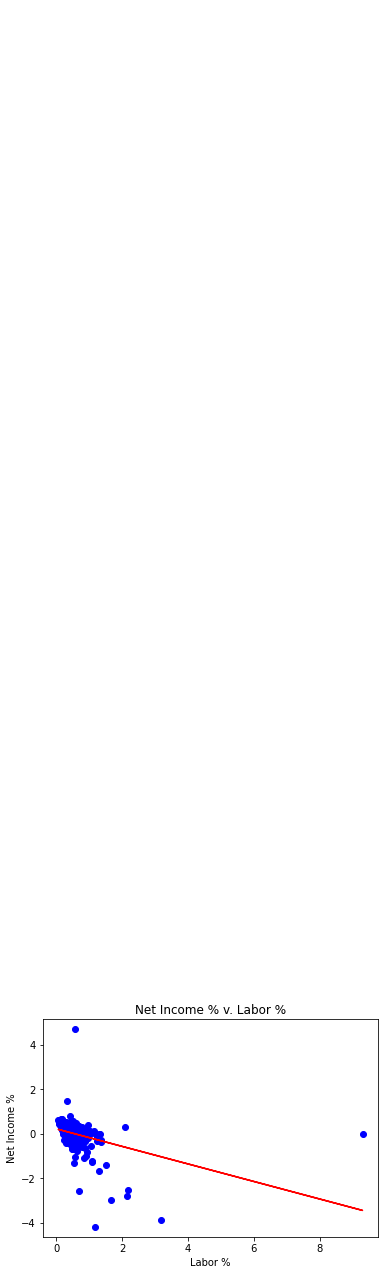

The correlation coefficient is -0.38
The line equation is as follows:  y = -0.39x + 0.22


In [245]:
#NI v. Labor Percent
targetFile6 = targetFile5
# targetFile6 = targetFile5.loc[targetFile5['Labor %'] <= .90]
# targetFile6 = targetFile6.loc[targetFile5['Net Income %'] <= .35]
# targetFile6 = targetFile6.loc[targetFile5['Net Income %'] >= -.25]
x_axis = targetFile6["Labor %"]
y_axis = targetFile6["Net Income %"]
plt.title("Net Income % v. Labor %")
plt.xlabel("Labor %")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [246]:
#Outlier Review
chartdata = targetFile5["Discharges Per FTE"]
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range is: {iqr}")
print(f"The the median of is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 32.78753791708797
The upper quartile is: 55.0977833485895
The interquartile range is: 22.310245431501535
The the median of is: 46.09932011795544 
Values below -0.6778302301643393 could be outliers.
Values above 88.56315149584181 could be outliers.


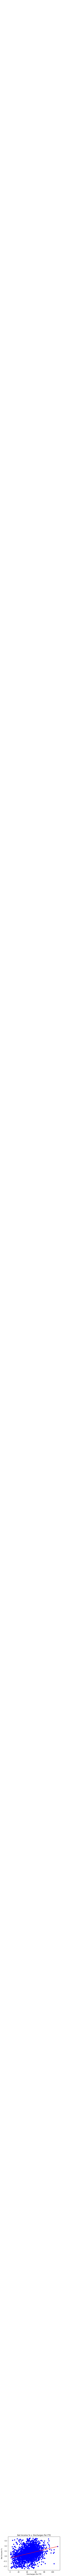

The correlation coefficient is 0.31
The line equation is as follows:  y = 0.0x + -0.04


In [248]:
#NI v. Labor Percent
targetFile6 = targetFile5
targetFile6 = targetFile5.loc[targetFile5['Discharges Per FTE'] <= 120]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] <= .35]
targetFile6 = targetFile6.loc[targetFile5['Net Income %'] >= -.25]
x_axis = targetFile6["Discharges Per FTE"]
y_axis = targetFile6["Net Income %"]
plt.title("Net Income % v. Discharges Per FTE")
plt.xlabel("Discharges Per FTE")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [92]:
#Start machine learning ...

In [93]:
# Select features to be used as x values
features1 = mainFile4[['CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev Per Discharge','Rev Per Bed','Rev Per Bed Days','Rev Per FTE','Discharges Per Bed','Discharges Per Bed Days','Discharges Per FTE','Labor %','Overhead %', 'Depreciation %','Labor Exp Per FTE', 'Overhead Exp Per Bed']]
features1.head()
#array([17, 18, 16, 13, 15, 10, 14,  8,  7,  2,  9, 11,  5,  3,  1,  6,  4, 12])

,CON,Urban,Inpatient %,Outpatient %,Charity %,Uncompensated %,Rev Per Discharge,Rev Per Bed,Rev Per Bed Days,Rev Per FTE,Discharges Per Bed,Discharges Per Bed Days,Discharges Per FTE,Labor %,Overhead %,Depreciation %,Labor Exp Per FTE,Overhead Exp Per Bed
0,1.0,1.0,0.311881,0.688119,0.003080,0.003080,19670.239080,1.222365e+05,1328.657453,26564.899100,6.214286,0.067547,6.214286,0.715116,0.627406,0.031451,18996.972990,76691.942857
1,1.0,0.0,0.325730,0.674270,0.001075,0.001075,16873.362245,5.167467e+04,847.125768,121408.920705,3.062500,0.050205,3.062500,0.509928,0.924882,0.073496,61909.838473,47792.984375
5,1.0,0.0,0.364763,0.635237,0.000905,0.000905,15444.529412,1.326604e+05,1105.503158,52406.586826,8.589474,0.071579,8.589474,0.414191,0.826683,0.119266,21706.316534,109668.063158
6,1.0,0.0,0.276917,0.723083,0.000780,0.000780,29768.443038,3.839522e+05,3199.601361,49737.365833,12.897959,0.107483,12.897959,0.478871,0.911870,0.043939,23817.770845,350114.346939
7,1.0,1.0,0.347411,0.652589,0.040733,0.040733,34343.975387,1.017440e+06,5590.331158,70460.869126,29.625000,0.162775,29.625000,0.734931,0.533090,0.031444,51783.861148,542387.437500


In [94]:
#Output features file as a reference document
features1.to_csv("mainFeatures.csv", index=False, header=True)

In [95]:
# ... Linear Regression Model

In [96]:
# Identify the outcome column/data
y = mainFile4[['Net Income %']]
y.head()

,Net Income %
0,0.308395
1,-0.337043
5,-0.132426
6,-0.291462
7,-0.050419


In [97]:
mainFile4["Net Income %"].dtype

dtype('float64')

In [98]:
y.shape

(2982, 1)

In [99]:
X = features1
X.shape

(2982, 18)

In [100]:
#Create a training and testing dataset - one hot
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)

In [101]:
y_train.shape

(2236, 1)

In [102]:
X_train.shape

(2236, 18)

In [103]:
y_test.shape

(746, 1)

In [104]:
X_test.shape

(746, 18)

In [105]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [106]:
#Create the linear regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LinearRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.3887245751486572


In [107]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: 0.5511071254583662


In [108]:
# ... Recursive Feature Elimination

In [109]:
#Identify features to create a more efficient model with
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train_scaled, y_train)

In [110]:
selector.support_

array([False, False,  True,  True,  True, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False])

In [111]:
selector.ranking_

array([13, 14,  1,  1,  1,  2,  8,  6, 10,  7,  1, 11,  1,  4,  3, 12,  9,
        5])

In [112]:
# ... Logistics Model

In [113]:
# Identify the outcome column/data
yy = mainFile4[['Net Income Score']]
yy.head()

,Net Income Score
0,1
1,3
5,3
6,3
7,3


In [114]:
yy.shape

(2982, 1)

In [115]:
XX = features1
XX.shape

(2982, 18)

In [116]:
#Create a training and testing dataset - one hot
X_train, X_test, y_train, y_test = train_test_split(
    XX, yy, random_state=1)

In [117]:
y_train.shape

(2236, 1)

In [118]:
X_train.shape

(2236, 18)

In [119]:
y_test.shape

(746, 1)

In [120]:
y_test.shape

(746, 1)

In [121]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [122]:
#Create the logistic regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LogisticRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.6104651162790697


C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [123]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: 0.6206434316353887


In [124]:
# ... recursive feature elimination

In [125]:
#Identify features to create a more efficient model with
estimator = LogisticRegression()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train_scaled, y_train)

C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

In [126]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False])

In [127]:
selector.ranking_

array([17, 18, 16, 13, 15, 10, 14,  8,  7,  2,  9, 11,  5,  3,  1,  6,  4,
       12])